Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


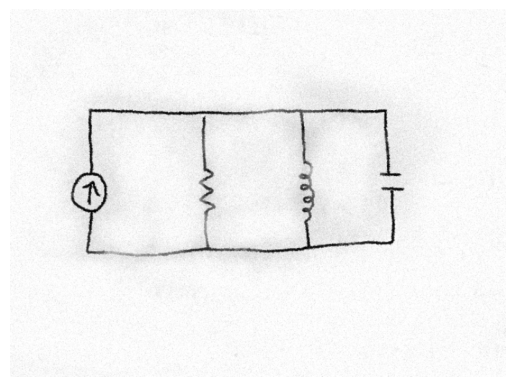

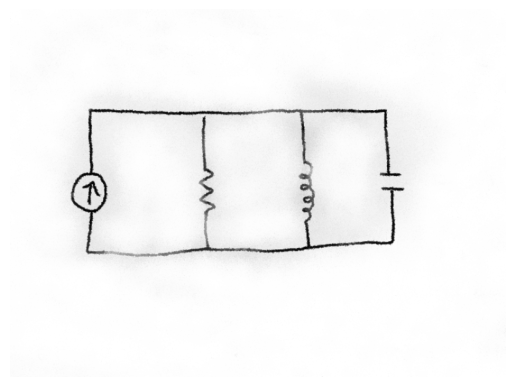

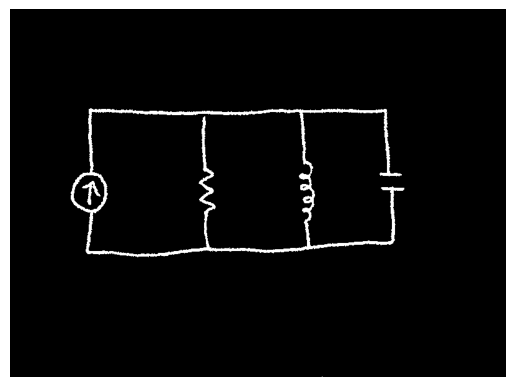

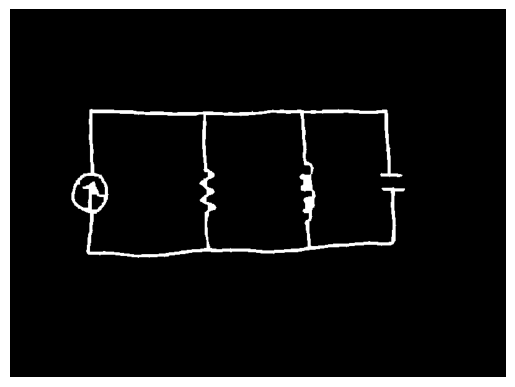

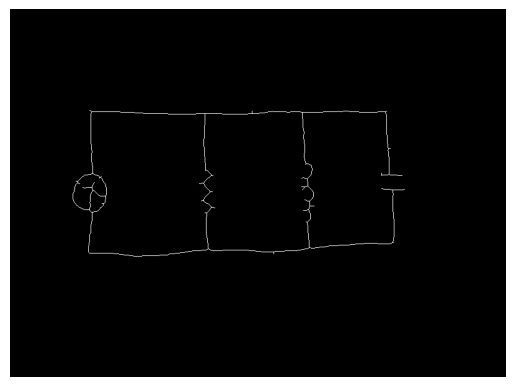

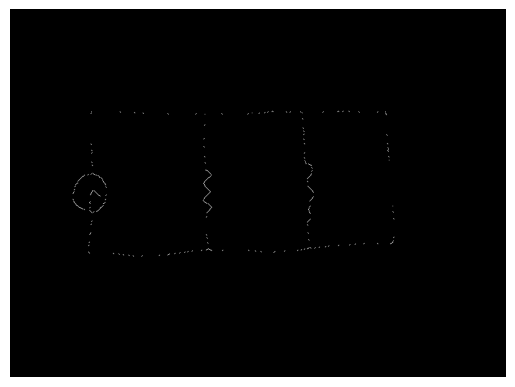

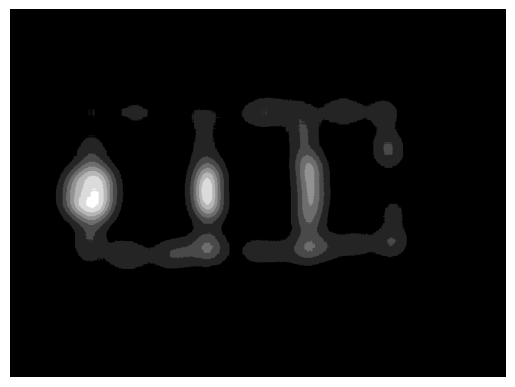

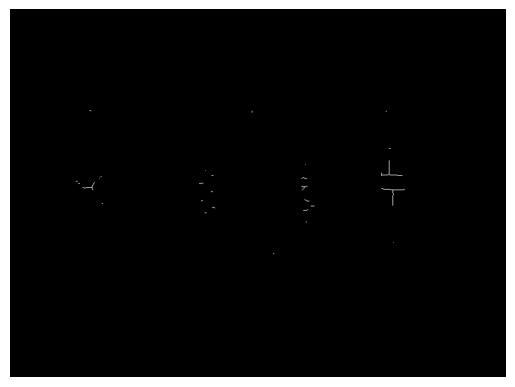

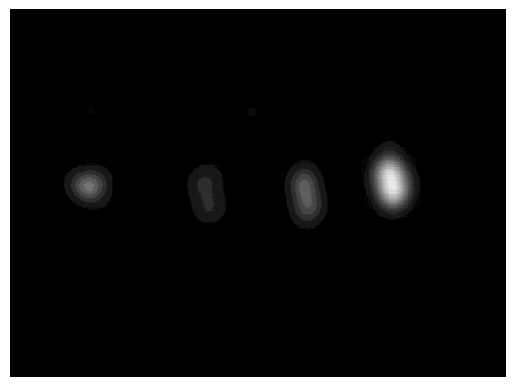

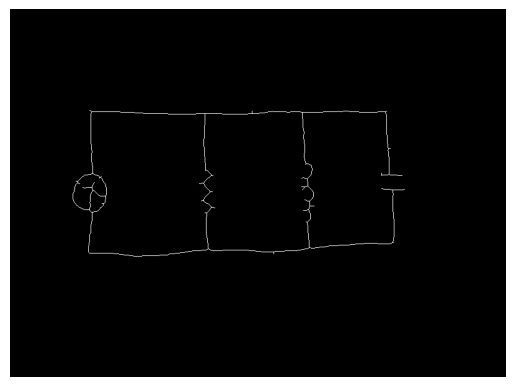

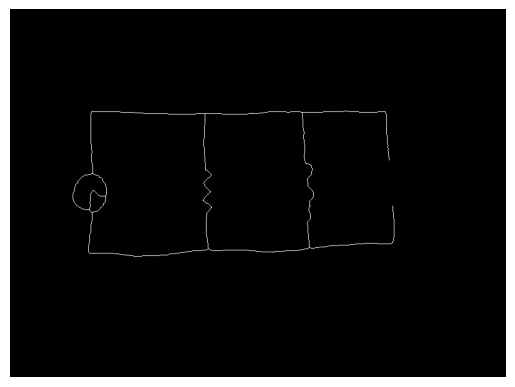

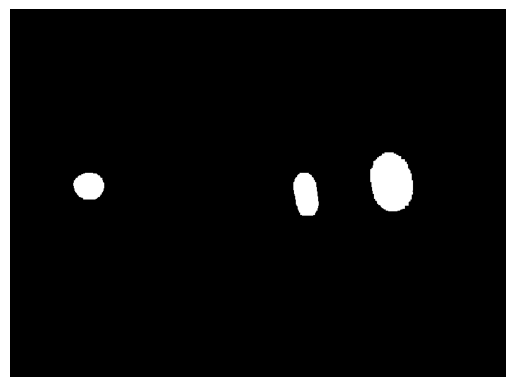

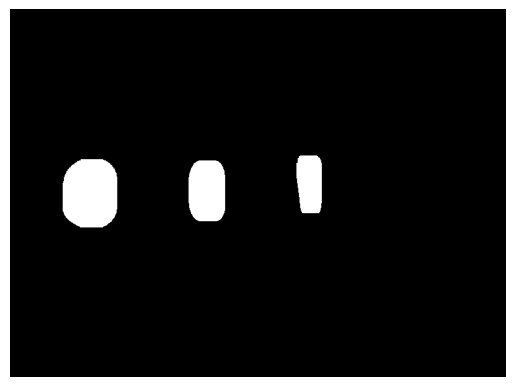

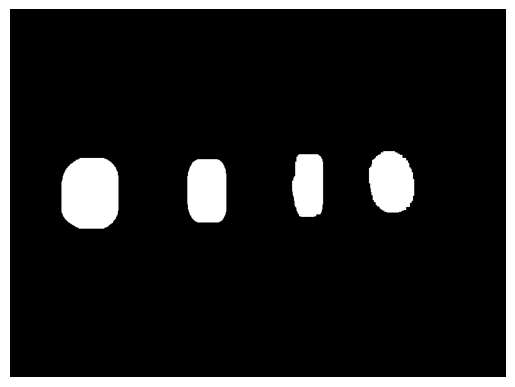

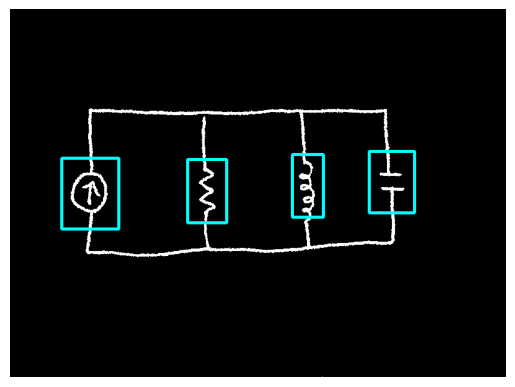

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def all_rotations(matrices):
    new_shape = (matrices.shape[0] * 4, matrices.shape[1], matrices.shape[2])
    new_matrices = np.zeros(new_shape, dtype=matrices.dtype)
    for i in range(len(matrices)):
        for rot in range(4):
            new_matrices[i * 4 + rot] = np.rot90(matrices[i], rot)
    return new_matrices

def reverse_hitmiss(img, kernels, num_iterations=None):
    dst = img.copy()

    i = 0
    while num_iterations == None or i < num_iterations:
        tmp = dst.copy()
        for k in kernels:
            tmp = tmp - cv2.morphologyEx(tmp, cv2.MORPH_HITMISS, k)

        if num_iterations == None and np.array_equal(dst, tmp):
            break

        dst = tmp
        i += 1
    return dst

def dilation(img, num_iterations=1):
    kernel = np.ones((3, 3))
    res = img.copy()
    for i in range(num_iterations):
        res = cv2.dilate(res, kernel)
    return res

kernels_thinning = np.array([[[0, -1, -1], [1, 1, -1], [0, 1, 0]],
                             [[-1, -1, -1], [0, 1, 0], [1, 1, 1]]])
kernels_thinning = all_rotations(kernels_thinning)
kernels_pruning = np.array([[[-1, -1, -1], [-1, 1, -1], [-1, 0, 0]],
                            [[-1, -1, -1], [-1, 1, -1], [0, 0, -1]]])
kernels_pruning = all_rotations(kernels_pruning)

kernels_straight = np.array([[[0, 0, 0], [1, 1, 1], [0, 0, 0]],
                             [[0, 1, 0], [0, 1, 0], [0, 1, 0]]])



img = cv2.imread('test23.png', cv2.IMREAD_GRAYSCALE)

new_width = 800
new_height = int(800 / (img.shape[1] / img.shape[0]))
img_resized = cv2.resize(img, (new_width, new_height))

plt.figure()
#plt.title('Original image')
plt.axis('off')
plt.imshow(img_resized, cmap='gray')

img_filtered = cv2.bilateralFilter(img_resized, 35, 10, 10)

plt.figure()
#plt.title('Filtered image')
plt.axis('off')
plt.imshow(img_filtered, cmap='gray')

avg_color = np.average(img_filtered)
if avg_color > 100:
    img_filtered = cv2.bitwise_not(img_filtered)
    avg_color = 255 - avg_color

img_thresh = cv2.adaptiveThreshold(img_filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, -20)

plt.figure()
#plt.title('Thresholded image')
plt.axis('off')
plt.imshow(img_thresh, cmap='gray')

img_closed = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, np.ones((8, 8)))
plt.figure()
#plt.title('Thresholded closed image')
plt.axis('off')
plt.imshow(img_closed, cmap='gray')

img_thinned = reverse_hitmiss(img_closed, kernels_thinning)
plt.figure()
#plt.title('Thinned image')
plt.axis('off')
plt.imshow(img_thinned, cmap='gray')

# Light pruning
out_img_pruned = reverse_hitmiss(img_closed, kernels_thinning)

# Heavy pruning
img_pruned = reverse_hitmiss(img_thinned, kernels_pruning, 22)

curved_lines = reverse_hitmiss(img_pruned, kernels_straight)
plt.figure()
#plt.title('Curved lines before Gaussian blur')
plt.axis('off')
plt.imshow(curved_lines, cmap='gray')
curved_lines = cv2.GaussianBlur(curved_lines, (101, 101), 0) * 2
plt.figure()
#plt.title('Curved lines before threshold')
plt.axis('off')
plt.imshow(curved_lines, cmap='gray')
curved_lines = cv2.threshold(curved_lines, 6, 255, cv2.THRESH_BINARY)[1]
curved_lines = dilation(curved_lines, 12)

endpoints = img_thinned - img_pruned
plt.figure()
#plt.title('Endpoints before Gaussian blur')
plt.axis('off')
plt.imshow(endpoints, cmap='gray')
endpoints = cv2.GaussianBlur(endpoints, (101, 101), 0) * 2
plt.figure()
#plt.title('Endpoints before threshold')
plt.axis('off')
plt.imshow(endpoints, cmap='gray')
endpoints = cv2.threshold(endpoints, 4, 255, cv2.THRESH_BINARY)[1]
endpoints = dilation(endpoints, 2)

elem_patches = dilation(endpoints + curved_lines, 2)

elem_rects = np.zeros((elem_patches.shape[0], elem_patches.shape[1], 3))
elem_contours, hier = cv2.findContours(elem_patches, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_area = (0.005 * elem_patches.shape[0] * elem_patches.shape[1])

for c in elem_contours:
    x, y, w, h = cv2.boundingRect(c)
    if w * h >= min_area:
        cv2.rectangle(elem_rects, (x, y), (x + w, y + h), (0.01, 1, 1), 3)

img_thresh_color = cv2.cvtColor(img_thresh, cv2.COLOR_GRAY2RGB)
elem_rects = np.where(elem_rects > 0, elem_rects, img_thresh_color)

plt.figure()
#plt.title('Thinned image')
plt.axis('off')
plt.imshow(img_thinned, cmap='gray')
plt.figure()
#plt.title('Pruned image')
plt.axis('off')
plt.imshow(img_pruned, cmap='gray')
plt.figure()
#plt.title('Endpoints')
plt.axis('off')
plt.imshow(endpoints, cmap='gray')
plt.figure()
#plt.title('Curved lines')
plt.axis('off')
plt.imshow(curved_lines, cmap='gray')
plt.figure()
#plt.title('Element patches')
plt.axis('off')
plt.imshow(elem_patches, cmap='gray')
plt.figure()
#plt.title('Element rectangles')
plt.axis('off')
plt.imshow(elem_rects, cmap='gray')